In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
# read python dict back from the file

# data_file = open('../data/SPK20220308/neuron_num_results/num_neuron_results.pkl', 'rb')
data_file = open('../data/SPK20220308/neuron_num_results/neuron_sort_results.pkl', 'rb')

num_neuron_dict = pickle.load(data_file)
data_file.close()

In [5]:
# num_repeats = num_neuron_dict['num_repeats']
# num_neuron_list = num_neuron_dict['num_neuron_list']

num_repeats = 5
num_neuron_list = [2,4,6,8,10,12,14,16,18,20,25,30]

task_res = list()
notask_res = list()
for repeat_idx in range(num_repeats):
    task_test_corr = list()
    notask_test_corr = list()
    for num_neurons in num_neuron_list:
        # res_dict = num_neuron_dict[f'repeat_{repeat_idx}'][f'num_neuron_{num_neurons}']
        res_dict = num_neuron_dict[f'fold_{repeat_idx}'][f'num_neuron_{num_neurons}']
        task_test_corr.append(np.stack(res_dict['rnn']['task']['test_corr']))
        notask_test_corr.append(np.stack(res_dict['rnn']['notask']['test_corr']))

    task_res.append(np.stack(task_test_corr))
    notask_res.append(np.stack(notask_test_corr))

task_res = np.stack(task_res)
notask_res = np.stack(notask_res)


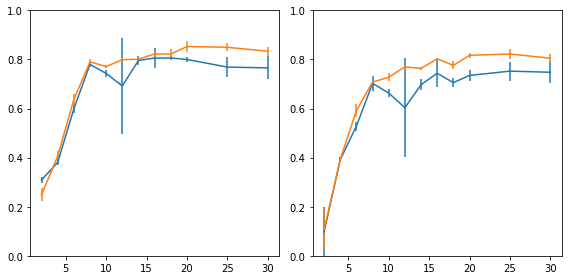

In [22]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(8,4))
for plot_idx in range(2):
    plt.subplot(1,2,plot_idx+1)
    plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx])
    plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx])
    # for repeat_idx in range(num_repeats):

    #     corr_diff = task_res[repeat_idx, :, plot_idx] - notask_res[repeat_idx, :, plot_idx]
    #     plt.plot(corr_diff)


    plt.tight_layout()
    plt.ylim(0.0,1)

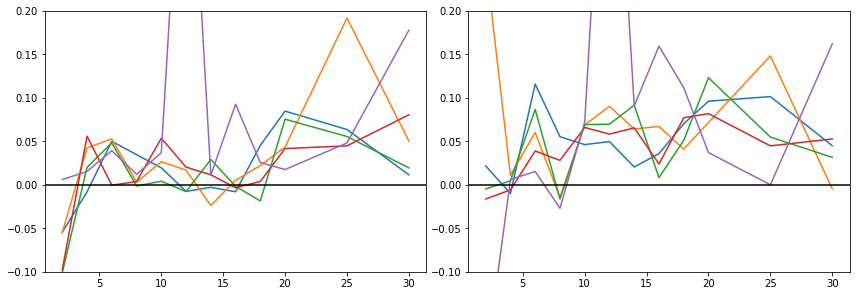

In [24]:
task_mean = np.mean(task_res, axis=0)
task_std = np.std(task_res,  axis=0)

notask_mean = np.mean(notask_res, axis=0)
notask_std = np.std(notask_res,  axis=0)

plt.figure(figsize=(12,12))
for plot_idx in range(2):
    plt.subplot(3,2,plot_idx+1)
    # plt.errorbar(x=num_neuron_list, y=notask_mean[:,plot_idx], yerr=notask_std[:,plot_idx])
    # plt.errorbar(x=num_neuron_list, y=task_mean[:,plot_idx], yerr=task_std[:,plot_idx])
    for repeat_idx in range(num_repeats):

        corr_diff = task_res[repeat_idx, :, plot_idx] - notask_res[repeat_idx, :, plot_idx]
        # plt.plot(task_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        # plt.plot(notask_res[repeat_idx, :, plot_idx], color=f'C{repeat_idx}')
        plt.plot(num_neuron_list, corr_diff)

    plt.tight_layout()
    plt.axhline(y=0, color='k')
    plt.ylim(-0.1, 0.2)

In [17]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [18]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

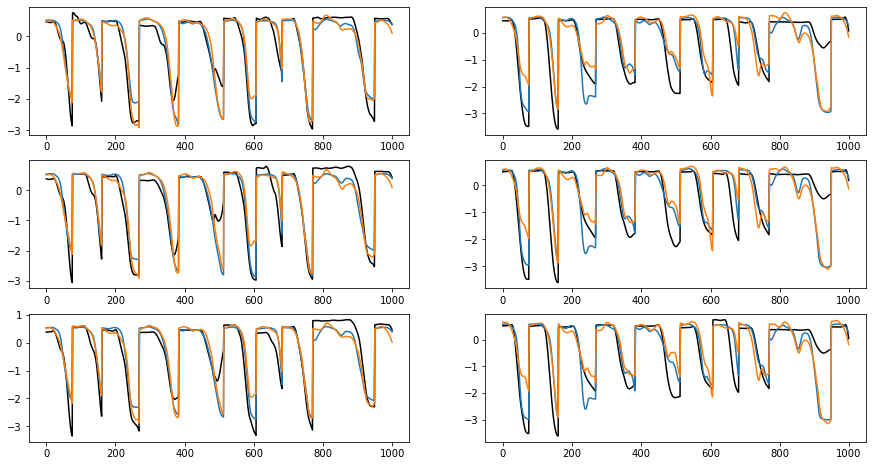

In [25]:
bounds = list(range(2000,3000))

repeat_name = 'repeat_1'
num_neuron_name = 'num_neuron_10'

plt.figure(figsize=(15,8))
for mrk_idx in range(6):
    plt.subplot(3,2,mrk_idx+1)
    plt.plot(y_test_data[bounds,mrk_idx], color='k')
    plt.plot(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['notask']['test_pred'][bounds,mrk_idx])
    plt.plot(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['task']['test_pred'][bounds,mrk_idx])


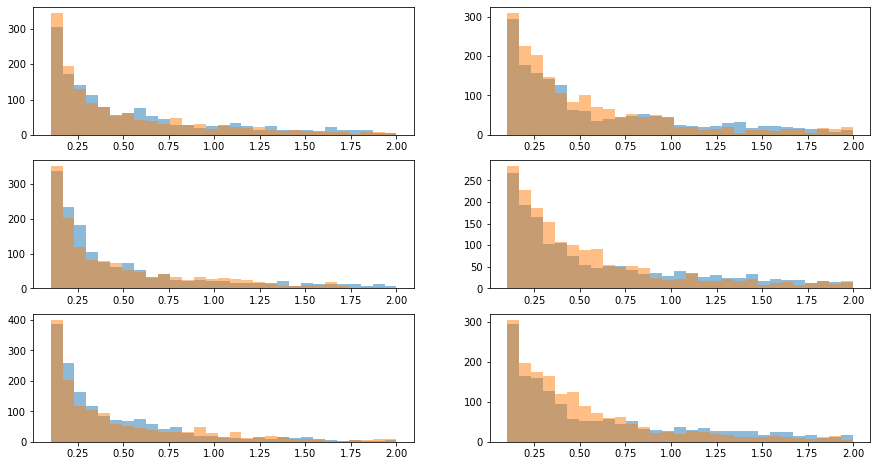

In [26]:
# repeat_name = 'repeat_3'
# num_neuron_name = 'num_neuron_30'

bins = np.linspace(0.1, 2, 30)
plt.figure(figsize=(15,8))
for mrk_idx in range(6):
    plt.subplot(3,2,mrk_idx+1)

    notask_mse = np.square(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])
    task_mse = np.square(num_neuron_dict[repeat_name][num_neuron_name]['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])

    plt.hist(notask_mse, bins=bins, alpha=0.5)
    plt.hist(task_mse, bins=bins, alpha=0.5)
